**GUIDE D'IMPORTATION DES DONNÉES - COLAB**

In [16]:
# ============================================
# 📂 GUIDE D'IMPORTATION DES DONNÉES - COLAB
# ============================================
# Pour les jurés de la compétition
# Durée estimée: ~35-40 minutes de training sur Colab

print("="*70)
print("🏆 INDIGENOUS WEATHER PREDICTION - SOLUTION TOP 10")
print("="*70)
print("\n📋 INSTRUCTIONS POUR LES JURÉS:\n")
print("Ce notebook nécessite les fichiers suivants:")
print("  • train_clean.csv")
print("  • test_clean.csv")
print("\n⏱️  Durée estimée d'exécution de tous le notebook: 40-50 minutes sur Colab (GPU T4)\n")
print("="*70 + "\n")

# ========================================
# MÉTHODE 1: UPLOAD MANUEL (RECOMMANDÉ)
# ========================================
print("📤 MÉTHODE 1: Upload Manuel depuis votre ordinateur")
print("-" * 70)
print("""
ÉTAPES:
1. Cliquez sur l'icône 📁 (dossier) dans la barre latérale gauche
2. Cliquez sur l'icône 📤 (upload)
3. Sélectionnez les fichiers:
   - train_clean.csv
   - test_clean.csv
4. Attendez la fin de l'upload (barre de progression)
""")

🏆 INDIGENOUS WEATHER PREDICTION - SOLUTION TOP 10

📋 INSTRUCTIONS POUR LES JURÉS:

Ce notebook nécessite les fichiers suivants:
  • train_clean.csv
  • test_clean.csv

⏱️  Durée estimée d'exécution de tous le notebook: 40-50 minutes sur Colab (GPU T4)


📤 MÉTHODE 1: Upload Manuel depuis votre ordinateur
----------------------------------------------------------------------

ÉTAPES:
1. Cliquez sur l'icône 📁 (dossier) dans la barre latérale gauche
2. Cliquez sur l'icône 📤 (upload) 
3. Sélectionnez les fichiers:
   - train_clean.csv
   - test_clean.csv
4. Attendez la fin de l'upload (barre de progression)



**train_phase**

In [1]:
#sur colab importer les fichier train et test dans votre environnement
# ===35 --30 min presque sur colab ====================================
# INSTALLATION
# ========================================
!pip install -q numpy pandas scikit-learn lightgbm xgboost catboost optuna

import warnings
warnings.filterwarnings("ignore")
import csv
from typing import Tuple
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

SEED = 42
np.random.seed(SEED)

print("✅ Imports terminés!\n")

# ==========================================================
# 🔥 ÉTAPE 1: REBUILD CLEAN CSVs (CODE AUTOMATISÉ)
# ==========================================================

_STR_NAN_TOKENS = {"nan", "NaN", "None", "none", ""}

def _strip_norm(df: pd.DataFrame) -> pd.DataFrame:
    """Trim + normalisation des tokens string -> NaN (sans toucher aux numériques)."""
    df = df.copy()
    for c in df.columns:
        if df[c].dtype == object:
            s = df[c].astype(str).str.strip()
            df[c] = s.replace(list(_STR_NAN_TOKENS), np.nan)
    return df

def _add_missing_flags(df: pd.DataFrame) -> pd.DataFrame:
    """Ajoute les 3 flags à la fin (mêmes noms/ordre que la référence)."""
    df = df.copy()
    df["is_missing_indicator"] = df["indicator"].isna().astype(int) if "indicator" in df else 0
    df["is_missing_indicator_description"] = (
        df["indicator_description"].isna().astype(int) if "indicator_description" in df else 0
    )
    df["is_missing_time_observed"] = df["time_observed"].isna().astype(int) if "time_observed" in df else 0
    return df

def _impute_text_unknown(df: pd.DataFrame) -> pd.DataFrame:
    """Impute 'Unknown' uniquement pour les colonnes texte (si présentes)."""
    df = df.copy()
    for col in ["indicator", "indicator_description", "time_observed"]:
        if col in df.columns:
            df[col] = df[col].fillna("Unknown")
    return df

def _canonical_columns_with_flags(original_csv_path: str) -> list:
    """Ordre des colonnes = ordre brut + 3 flags à la fin (comme la référence)."""
    base_cols = list(pd.read_csv(original_csv_path, nrows=0).columns)
    return base_cols + [
        "is_missing_indicator",
        "is_missing_indicator_description",
        "is_missing_time_observed",
    ]

def _save_canonical(df: pd.DataFrame, out_path: str) -> None:
    """Sauvegarde byte-stable : utf-8, \n, quoting minimal, pas d'index, pas de float_format."""
    df.to_csv(
        out_path,
        index=False,
        encoding="utf-8",
        lineterminator="\n",
        quoting=csv.QUOTE_MINIMAL,
    )

def rebuild_clean_files(
    raw_train_path: str,
    raw_test_path: str,
    out_train_clean_path: str,
    out_test_clean_path: str,
) -> Tuple[Tuple[int, int], Tuple[int, int]]:
    """
    Lit les CSV bruts, applique exactement le nettoyage validé, et écrit
    des fichiers propres déterministes (identiques aux références).

    Retourne les shapes (lignes, colonnes) des deux sorties.
    """
    # 1) Lire bruts
    train = pd.read_csv(raw_train_path)
    test = pd.read_csv(raw_test_path)

    # 2) Trim + normalisation tokens -> NaN
    train = _strip_norm(train)
    test = _strip_norm(test)

    # 3) Ajouter flags
    train = _add_missing_flags(train)
    test  = _add_missing_flags(test)

    # 4) Imputer textes manquants -> "Unknown"
    train = _impute_text_unknown(train)
    test  = _impute_text_unknown(test)

    # 5) ID string, Target uppercase (train)
    if "ID" in train.columns:
        train["ID"] = train["ID"].astype(str).str.strip()
    if "ID" in test.columns:
        test["ID"] = test["ID"].astype(str).str.strip()
    if "Target" in train.columns and train["Target"].dtype == object:
        train["Target"] = train["Target"].str.upper().str.strip()

    # 6) Ordre des colonnes = ordre brut + flags (aucun tri des lignes)
    train_cols = _canonical_columns_with_flags(raw_train_path)
    test_cols  = _canonical_columns_with_flags(raw_test_path)

    train = train.reindex(columns=train_cols)
    test  = test.reindex(columns=test_cols)

    # 7) Sauvegarde canonique (byte-stable)
    _save_canonical(train, out_train_clean_path)
    _save_canonical(test,  out_test_clean_path)

    return train.shape, test.shape

# ========================================
# 🚀 ÉTAPE 1: EXÉCUTER LE NETTOYAGE
# ========================================
print(f"{'='*60}")
print("🧹 ÉTAPE 1: NETTOYAGE AUTOMATIQUE DES FICHIERS")
print(f"{'='*60}\n")

train_shape, test_shape = rebuild_clean_files(
    raw_train_path="/content/train.csv",
    raw_test_path="/content/test.csv",
    out_train_clean_path="train_clean.csv",
    out_test_clean_path="test_clean.csv",
)
print(f"✅ Fichiers propres générés!")
print(f"   train_clean: {train_shape}")
print(f"   test_clean: {test_shape}\n")

# ========================================
# CHARGEMENT
# ========================================
train = pd.read_csv('train_clean.csv')
test = pd.read_csv('test_clean.csv')

print(f"✓ Train: {train.shape}")
print(f"✓ Test: {test.shape}")
print(f"\n📈 Distribution Target:")
print(train['Target'].value_counts(normalize=True))
print(f"\n{'='*60}\n")

# ========================================
# 🔥 FEATURE ENGINEERING AVANCÉ
# ========================================
def advanced_features(df, is_train=True, text_vectorizer=None, fit_text=False):
    """Feature engineering ultra-puissant"""
    df = df.copy()

    # Temps
    df['prediction_time'] = pd.to_datetime(df['prediction_time'])
    df['hour'] = df['prediction_time'].dt.hour
    df['day'] = df['prediction_time'].dt.day
    df['month'] = df['prediction_time'].dt.month
    df['dayofweek'] = df['prediction_time'].dt.dayofweek
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    df['week_of_year'] = df['prediction_time'].dt.isocalendar().week
    df['day_of_year'] = df['prediction_time'].dt.dayofyear

    # Cycliques (IMPORTANT pour météo!)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
    df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)

    # Périodes jour
    df['is_morning'] = ((df['hour'] >= 6) & (df['hour'] < 12)).astype(int)
    df['is_afternoon'] = ((df['hour'] >= 12) & (df['hour'] < 18)).astype(int)
    df['is_evening'] = ((df['hour'] >= 18) & (df['hour'] < 22)).astype(int)
    df['is_night'] = ((df['hour'] >= 22) | (df['hour'] < 6)).astype(int)

    # Saisons Ghana
    df['rainy_main'] = ((df['month'] >= 4) & (df['month'] <= 6)).astype(int)
    df['rainy_secondary'] = ((df['month'] >= 9) & (df['month'] <= 11)).astype(int)
    df['dry_season'] = ((df['rainy_main'] == 0) & (df['rainy_secondary'] == 0)).astype(int)

    # Interactions multiples
    df['conf_x_intensity'] = df['confidence'] * df['predicted_intensity']
    df['conf_squared'] = df['confidence'] ** 2
    df['conf_cubed'] = df['confidence'] ** 3
    df['intensity_x_forecast'] = df['predicted_intensity'] * df['forecast_length']
    df['conf_x_forecast'] = df['confidence'] * df['forecast_length']
    df['conf_x_hour'] = df['confidence'] * df['hour']
    df['conf_x_rainy'] = df['confidence'] * (df['rainy_main'] + df['rainy_secondary'])

    # Bins de confiance
    df['conf_bins'] = pd.cut(df['confidence'], bins=10, labels=False)

    # Features manquantes
    df['has_indicator'] = df['indicator'].notna().astype(int)
    df['has_indicator_desc'] = df['indicator_description'].notna().astype(int)
    df['has_time_observed'] = df['time_observed'].notna().astype(int)
    df['missing_count'] = (3 - df['has_indicator'] - df['has_indicator_desc'] - df['has_time_observed'])

    # Text features (TF-IDF sur indicator_description)
    if 'indicator_description' in df.columns:
        if fit_text:
            text_data = df['indicator_description'].fillna('missing').astype(str)
            text_vectorizer = TfidfVectorizer(
                max_features=50,
                ngram_range=(1, 2),
                min_df=2,
                stop_words='english'
            )
            text_matrix = text_vectorizer.fit_transform(text_data)
            text_df = pd.DataFrame(
                text_matrix.toarray(),
                columns=[f'tfidf_{i}' for i in range(text_matrix.shape[1])]
            )
            df = pd.concat([df.reset_index(drop=True), text_df], axis=1)
        elif text_vectorizer is not None:
            text_data = df['indicator_description'].fillna('missing').astype(str)
            text_matrix = text_vectorizer.transform(text_data)
            text_df = pd.DataFrame(
                text_matrix.toarray(),
                columns=[f'tfidf_{i}' for i in range(text_matrix.shape[1])]
            )
            df = pd.concat([df.reset_index(drop=True), text_df], axis=1)

    return df, text_vectorizer

# Feature engineering
print("🔧 Feature Engineering avancé...")
train, text_vec = advanced_features(train, is_train=True, fit_text=True)
test, _ = advanced_features(test, is_train=False, text_vectorizer=text_vec)

# ========================================
# AGRÉGATIONS GLOBALES
# ========================================
print("📊 Création des agrégations globales...")

train_original = train.copy()
test_original = test.copy()

# USER STATS
user_stats_global = train.groupby('user_id').agg({
    'confidence': ['mean', 'std', 'min', 'max', 'count'],
    'predicted_intensity': ['mean', 'sum'],
    'forecast_length': 'mean'
}).reset_index()
user_stats_global.columns = ['user_id'] + [f'user_{col[0]}_{col[1]}' for col in user_stats_global.columns[1:]]
user_stats_global['user_confidence_std'] = user_stats_global['user_confidence_std'].fillna(0)

# COMMUNITY STATS
comm_stats_global = train.groupby('community').agg({
    'confidence': ['mean', 'std'],
    'predicted_intensity': 'mean',
    'Target': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'NORAIN'
}).reset_index()
comm_stats_global.columns = ['community', 'comm_conf_mean', 'comm_conf_std', 'comm_intensity_mean', 'comm_target_mode']
comm_stats_global['comm_conf_std'] = comm_stats_global['comm_conf_std'].fillna(0)

# DISTRICT STATS
dist_stats_global = train.groupby('district').agg({
    'confidence': 'mean',
    'predicted_intensity': 'mean',
    'Target': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'NORAIN'
}).reset_index()
dist_stats_global.columns = ['district', 'dist_conf_mean', 'dist_intensity_mean', 'dist_target_mode']

# TIME-BASED STATS
train['hour_block'] = (train['hour'] // 4)
test['hour_block'] = (test['hour'] // 4)
time_stats_global = train.groupby('hour_block').agg({
    'confidence': 'mean',
    'Target': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'NORAIN'
}).reset_index()
time_stats_global.columns = ['hour_block', 'hourblock_conf_mean', 'hourblock_target_mode']

# Merge global
train = train.merge(user_stats_global, on='user_id', how='left')
train = train.merge(comm_stats_global, on='community', how='left')
train = train.merge(dist_stats_global, on='district', how='left')
train = train.merge(time_stats_global, on='hour_block', how='left')

test = test.merge(user_stats_global, on='user_id', how='left')
test = test.merge(comm_stats_global, on='community', how='left')
test = test.merge(dist_stats_global, on='district', how='left')
test = test.merge(time_stats_global, on='hour_block', how='left')

# Fill NaN
for col in train.columns:
    if train[col].dtype in ['float64', 'int64']:
        train[col] = train[col].fillna(0)
        test[col] = test[col].fillna(0)

for col in ['comm_target_mode', 'dist_target_mode', 'hourblock_target_mode']:
    if col in train.columns:
        train[col] = train[col].fillna('NORAIN')
        test[col] = test[col].fillna('NORAIN')

print("✓ Agrégations créées")

# ========================================
# ENCODING CATÉGORIES
# ========================================
print("🔢 Encoding des catégories...")

for col in ['community', 'district', 'indicator']:
    le = LabelEncoder()
    train[col] = train[col].fillna('missing').astype(str)
    test[col] = test[col].fillna('missing').astype(str)
    all_vals = pd.concat([train[col], test[col]]).unique()
    le.fit(all_vals)
    train[col] = le.transform(train[col])
    test[col] = le.transform(test[col])

for col in ['comm_target_mode', 'dist_target_mode', 'hourblock_target_mode']:
    if col in train.columns:
        le = LabelEncoder()
        all_vals = pd.concat([train[col], test[col]]).unique()
        le.fit(all_vals)
        train[col] = le.transform(train[col])
        test[col] = le.transform(test[col])

print("✓ Encoding terminé")

# ========================================
# FONCTION AGREGATIONS LEAK-SAFE POUR CV
# ========================================
def add_aggregations_cv(train_df, val_df, test_df):
    """Recalcule UNIQUEMENT les user stats sur train_fold (leak-safe)"""
    user_stats = train_df.groupby('user_id').agg({
        'confidence': ['mean', 'std', 'min', 'max', 'count'],
        'predicted_intensity': ['mean', 'sum'],
        'forecast_length': 'mean'
    }).reset_index()
    user_stats.columns = ['user_id'] + [f'user_{col[0]}_{col[1]}' for col in user_stats.columns[1:]]
    user_stats['user_confidence_std'] = user_stats['user_confidence_std'].fillna(0)

    for df in [val_df, test_df]:
        user_cols_to_drop = [c for c in df.columns if c.startswith('user_') and c != 'user_id']
        df.drop(columns=user_cols_to_drop, inplace=True, errors='ignore')

    val_df = val_df.merge(user_stats, on='user_id', how='left')
    test_df = test_df.merge(user_stats, on='user_id', how='left')

    for col in user_stats.columns[1:]:
        val_df[col] = val_df[col].fillna(0)
        test_df[col] = test_df[col].fillna(0)

    return val_df, test_df

# ========================================
# TARGET ENCODING
# ========================================
target_encoder = LabelEncoder()
y_train = target_encoder.fit_transform(train['Target'])
n_classes = len(target_encoder.classes_)

print(f"\n✓ Classes: {target_encoder.classes_}")

# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
print(f"✓ Class weights: {class_weight_dict}\n")

# ========================================
# FEATURES FINALES
# ========================================
drop_cols = ['ID', 'prediction_time', 'indicator_description', 'time_observed', 'Target']
feature_cols = [col for col in train.columns if col not in drop_cols]

print(f"✓ {len(feature_cols)} features utilisées\n")

# ========================================
# 🚀 ENTRAÎNEMENT AVEC STRATIFIED K-FOLD
# ========================================
print(f"{'='*60}")
print("🚀 ENTRAÎNEMENT STRATIFIED 10-FOLD")
print(f"{'='*60}\n")

n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)

oof_preds_lgb = np.zeros((len(train), n_classes))
oof_preds_xgb = np.zeros((len(train), n_classes))
oof_preds_cat = np.zeros((len(train), n_classes))

test_preds_lgb = np.zeros((len(test), n_classes))
test_preds_xgb = np.zeros((len(test), n_classes))
test_preds_cat = np.zeros((len(test), n_classes))

f1_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(train, y_train)):
    print(f"\n{'='*60}")
    print(f"📍 FOLD {fold + 1}/{n_splits}")
    print(f"{'='*60}")

    train_fold_raw = train_original.iloc[train_idx].copy()
    val_fold = train.iloc[val_idx].copy()
    test_fold = test.copy()

    val_fold, test_fold = add_aggregations_cv(train_fold_raw, val_fold, test_fold)

    X_tr = train.iloc[train_idx][feature_cols].fillna(-999)
    X_val = val_fold[feature_cols].fillna(-999)
    X_te = test_fold[feature_cols].fillna(-999)

    y_tr = y_train[train_idx]
    y_val = y_train[val_idx]

    # LightGBM
    print("\n🌟 LightGBM...")
    lgb_params = {
        'objective': 'multiclass',
        'num_class': n_classes,
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
        'learning_rate': 0.01,
        'num_leaves': 127,
        'max_depth': 10,
        'min_child_samples': 10,
        'subsample': 0.7,
        'colsample_bytree': 0.7,
        'reg_alpha': 0.5,
        'reg_lambda': 0.5,
        'random_state': SEED,
        'verbose': -1,
        'is_unbalance': True
    }

    sample_weights_tr = np.array([class_weights[y] for y in y_tr])
    sample_weights_val = np.array([class_weights[y] for y in y_val])

    lgb_train = lgb.Dataset(X_tr, label=y_tr, weight=sample_weights_tr)
    lgb_val = lgb.Dataset(X_val, label=y_val, weight=sample_weights_val, reference=lgb_train)

    lgb_model = lgb.train(
        lgb_params,
        lgb_train,
        num_boost_round=3000,
        valid_sets=[lgb_train, lgb_val],
        callbacks=[lgb.early_stopping(200), lgb.log_evaluation(500)]
    )

    oof_preds_lgb[val_idx] = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration)
    test_preds_lgb += lgb_model.predict(X_te, num_iteration=lgb_model.best_iteration) / n_splits

    # XGBoost
    print("\n🌟 XGBoost...")
    xgb_params = {
        'objective': 'multi:softprob',
        'num_class': n_classes,
        'eval_metric': 'mlogloss',
        'learning_rate': 0.01,
        'max_depth': 10,
        'min_child_weight': 1,
        'subsample': 0.7,
        'colsample_bytree': 0.7,
        'reg_alpha': 0.5,
        'reg_lambda': 0.5,
        'random_state': SEED,
        'tree_method': 'hist'
    }

    sample_weights = np.array([class_weights[y] for y in y_tr])
    dtrain = xgb.DMatrix(X_tr, label=y_tr, weight=sample_weights)
    dval = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_te)

    xgb_model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=3000,
        evals=[(dtrain, 'train'), (dval, 'val')],
        early_stopping_rounds=200,
        verbose_eval=500
    )

    oof_preds_xgb[val_idx] = xgb_model.predict(dval)
    test_preds_xgb += xgb_model.predict(dtest) / n_splits

    # CatBoost
    print("\n🌟 CatBoost...")
    cat_class_weights = [class_weights[i] for i in range(n_classes)]

    cat_model = CatBoostClassifier(
        iterations=3000,
        learning_rate=0.01,
        depth=10,
        l2_leaf_reg=10,
        auto_class_weights='Balanced',
        random_state=SEED,
        loss_function='MultiClass',
        eval_metric='TotalF1:average=Macro',
        early_stopping_rounds=200,
        verbose=500,
        task_type='CPU'
    )

    cat_model.fit(
        X_tr, y_tr,
        eval_set=(X_val, y_val),
        use_best_model=True
    )

    oof_preds_cat[val_idx] = cat_model.predict_proba(X_val)
    test_preds_cat += cat_model.predict_proba(X_te) / n_splits

    # Ensemble
    oof_ensemble = (oof_preds_lgb[val_idx] * 0.35 +
                    oof_preds_xgb[val_idx] * 0.35 +
                    oof_preds_cat[val_idx] * 0.30)

    fold_preds = np.argmax(oof_ensemble, axis=1)
    fold_f1 = f1_score(y_val, fold_preds, average='macro')
    f1_scores.append(fold_f1)

    print(f"\n✅ Fold {fold + 1} Macro F1: {fold_f1:.6f}")

# ========================================
# STACKING
# ========================================
print(f"\n{'='*60}")
print("🔬 STACKING META-LEARNER")
print(f"{'='*60}\n")

oof_stack = np.hstack([oof_preds_lgb, oof_preds_xgb, oof_preds_cat])
meta_model = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=2000,
    C=0.1,
    class_weight='balanced',
    random_state=SEED
)
meta_model.fit(oof_stack, y_train)

oof_meta_preds = meta_model.predict(oof_stack)
oof_meta_f1 = f1_score(y_train, oof_meta_preds, average='macro')

print(f"✓ Meta F1: {oof_meta_f1:.6f}")
print(f"✓ Base F1: {np.mean(f1_scores):.6f}")
print(f"✓ Amélioration: +{oof_meta_f1 - np.mean(f1_scores):.6f}\n")

# ========================================
# PRÉDICTIONS FINALES
# ========================================
test_stack = np.hstack([test_preds_lgb, test_preds_xgb, test_preds_cat])
final_predictions = meta_model.predict(test_stack)
final_predictions_labels = target_encoder.inverse_transform(final_predictions)

# ========================================
# SOUMISSION
# ========================================
submission = pd.DataFrame({
    'ID': test['ID'],
    'Target': final_predictions_labels
})

submission.to_csv('submission.csv', index=False)

print(f"{'='*60}")
print("🎉 SOUMISSION CRÉÉE!")
print(f"{'='*60}")
print(f"\n📈 Distribution:")
print(submission['Target'].value_counts())
print(f"\n💪 Macro F1 estimé: {oof_meta_f1:.6f}")
print(f"📉 Std CV: {np.std(f1_scores):.6f}")

# La ligne ci-dessous est spécifique à Colab pour télécharger le fichier
# from google.colab import files
# files.download('submission.csv')

print(f"\n{'='*60}")
print("🏆 OPTIMISATIONS APPLIQUÉES:")
print("✓ Features cycliques (sin/cos)")
print("✓ TF-IDF sur texte")
print("✓ Stats par time-block")
print("✓ Target mode par geo")
print("✓ 10-fold au lieu de 5")
print("✓ 3000 rounds + early stopping")
print("✓ Hyperparamètres optimisés")
print(f"{'='*60}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 10.8 MB/s eta 0:00:00
✅ Imports terminés!

🧹 ÉTAPE 1: NETTOYAGE AUTOMATIQUE DES FICHIERS

✅ Fichiers propres générés!
   train_clean: (10928, 15)
   test_clean: (2732, 14)

✓ Train: (10928, 15)
✓ Test: (2732, 14)

📈 Distribution Target:
Target
NORAIN        0.879575
MEDIUMRAIN    0.069638
HEAVYRAIN     0.028825
SMALLRAIN     0.021962
Name: proportion, dtype: float64


🔧 Feature Engineering avancé...
📊 Création des agrégations globales...
✓ Agrégations créées
🔢 Encoding des catégories...
✓ Encoding terminé

✓ Classes: ['HEAVYRAIN' 'MEDIUMRAIN' 'NORAIN' 'SMALLRAIN']
✓ Class weights: {0: np.float64(8.673015873015872), 1: np.float64(3.590013140604468), 2: np.float64(0.2842280482729921), 3: np.float64(11.383333333333333)}

✓ 110 features utilisées

🚀 ENTRAÎNEMENT STRATIFIED 10-FOLD


📍 FOLD 1/10

🌟 LightGBM...
Training until validation scores don't improve

**ceci l'exportation des modéles (tflite + onnx)**

In [3]:
# ==========8 min presque==================================
# ========= tu vas obtient le zip a cote dans lé environnement colab==================================
# 🏆 EXPORT COMPLET - TOUS LES FORMATS
# ============================================
# Crée 4 modèles TFLite + ONNX + ZIP final

!pip install -q numpy pandas scikit-learn lightgbm xgboost catboost optuna onnx onnxruntime skl2onnx onnxmltools hummingbird-ml tensorflow


import os
import pickle
import numpy as np
import warnings
import zipfile
from datetime import datetime
warnings.filterwarnings('ignore')

# Configuration CPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

print("🚀 EXPORT COMPLET - TOUS LES FORMATS")
print("="*60 + "\n")

import tensorflow as tf
from tensorflow import keras

# ========================================
# VÉRIFICATION
# ========================================
required_vars = [
    'train', 'feature_cols', 'y_train', 'n_classes',
    'class_weights', 'target_encoder', 'text_vec',
    'user_stats_global', 'comm_stats_global',
    'dist_stats_global', 'time_stats_global', 'SEED'
]

missing = [v for v in required_vars if v not in globals()]
if missing:
    raise RuntimeError(f"❌ Variables manquantes: {missing}")

print("✅ Variables validées\n")

# ========================================
# PRÉPARATION
# ========================================
save_dir = 'models_final_export'
os.makedirs(save_dir, exist_ok=True)

X_full = train[feature_cols].fillna(-999)
y_full = y_train
sample_weights_full = np.array([class_weights[y] for y in y_full])

X_full_numeric = X_full.copy()
X_full_numeric.columns = range(len(X_full.columns))
feature_name_mapping = dict(zip(range(len(feature_cols)), feature_cols))

print(f"📊 Données: {X_full_numeric.shape}")
print(f"📊 Classes: {n_classes}\n")

# ========================================
# 1. LIGHTGBM → ONNX
# ========================================
print("🌟 [1/7] LightGBM → ONNX...")

import lightgbm as lgb
import hummingbird.ml as hml

lgb_params = {
    'objective': 'multiclass',
    'num_class': n_classes,
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 127,
    'max_depth': 10,
    'min_child_samples': 10,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'reg_alpha': 0.5,
    'reg_lambda': 0.5,
    'random_state': SEED,
    'verbose': -1,
    'is_unbalance': True
}

lgb_data = lgb.Dataset(X_full_numeric, label=y_full, weight=sample_weights_full)
lgb_model = lgb.train(lgb_params, lgb_data, num_boost_round=2000,
                      callbacks=[lgb.log_evaluation(500)])

test_input = X_full_numeric[:1].values.astype(np.float32)
lgb_onnx = hml.convert(lgb_model, 'onnx', test_input=test_input)
lgb_onnx.save(os.path.join(save_dir, 'lightgbm_model.onnx'))
print("   ✅ LightGBM → ONNX\n")

# ========================================
# 2. XGBOOST → ENTRAÎNEMENT
# ========================================
print("🌟 [2/7] Entraînement XGBoost...")

from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    objective='multi:softprob',
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=10,
    subsample=0.7,
    colsample_bytree=0.7,
    random_state=SEED,
    tree_method='hist'
)
xgb_model.fit(X_full_numeric, y_full, sample_weight=sample_weights_full, verbose=500)
xgb_probs = xgb_model.predict_proba(X_full_numeric)
print("   ✅ XGBoost entraîné\n")

# ========================================
# 3. CATBOOST → ENTRAÎNEMENT
# ========================================
print("🌟 [3/7] Entraînement CatBoost...")

from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.01,
    depth=10,
    auto_class_weights='Balanced',
    random_state=SEED,
    verbose=500
)
cat_model.fit(X_full_numeric, y_full)
cat_probs = cat_model.predict_proba(X_full_numeric.values)
print("   ✅ CatBoost entraîné\n")

# ========================================
# 4. XGBOOST → TFLITE (INDIVIDUEL)
# ========================================
print("🌟 [4/7] XGBoost → TFLite (distillation)...")

y_onehot = keras.utils.to_categorical(y_full, n_classes)

with tf.device('/CPU:0'):
    nn_xgb = keras.Sequential([
        keras.layers.Input(shape=(X_full_numeric.shape[1],)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(n_classes, activation='softmax')
    ], name='xgb_distilled')

    nn_xgb.compile(
        optimizer=keras.optimizers.Adam(0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Mix: 70% XGBoost, 30% truth
    y_mixed_xgb = 0.7 * xgb_probs + 0.3 * y_onehot

    nn_xgb.fit(
        X_full_numeric.values.astype(np.float32),
        y_mixed_xgb,
        epochs=100,
        batch_size=256,
        validation_split=0.2,
        callbacks=[
            keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)
        ],
        verbose=0
    )

# Export TFLite
converter_xgb = tf.lite.TFLiteConverter.from_keras_model(nn_xgb)
converter_xgb.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_xgb = converter_xgb.convert()

with open(os.path.join(save_dir, 'xgboost_model.tflite'), 'wb') as f:
    f.write(tflite_xgb)
print("   ✅ XGBoost → TFLite\n")

# ========================================
# 5. CATBOOST → TFLITE (INDIVIDUEL)
# ========================================
print("🌟 [5/7] CatBoost → TFLite (distillation)...")

with tf.device('/CPU:0'):
    nn_cat = keras.Sequential([
        keras.layers.Input(shape=(X_full_numeric.shape[1],)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(n_classes, activation='softmax')
    ], name='cat_distilled')

    nn_cat.compile(
        optimizer=keras.optimizers.Adam(0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    y_mixed_cat = 0.7 * cat_probs + 0.3 * y_onehot

    nn_cat.fit(
        X_full_numeric.values.astype(np.float32),
        y_mixed_cat,
        epochs=100,
        batch_size=256,
        validation_split=0.2,
        callbacks=[
            keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)
        ],
        verbose=0
    )

converter_cat = tf.lite.TFLiteConverter.from_keras_model(nn_cat)
converter_cat.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_cat = converter_cat.convert()

with open(os.path.join(save_dir, 'catboost_model.tflite'), 'wb') as f:
    f.write(tflite_cat)
print("   ✅ CatBoost → TFLite\n")

# ========================================
# 6. ENSEMBLE → TFLITE
# ========================================
print("🌟 [6/7] Ensemble des 3 → TFLite...")

lgb_probs = lgb_model.predict(X_full_numeric.values)
ensemble_probs = (lgb_probs + xgb_probs + cat_probs) / 3

with tf.device('/CPU:0'):
    nn_ensemble = keras.Sequential([
        keras.layers.Input(shape=(X_full_numeric.shape[1],)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(n_classes, activation='softmax')
    ], name='ensemble')

    nn_ensemble.compile(
        optimizer=keras.optimizers.Adam(0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    y_mixed_ensemble = 0.8 * ensemble_probs + 0.2 * y_onehot

    history_ensemble = nn_ensemble.fit(
        X_full_numeric.values.astype(np.float32),
        y_mixed_ensemble,
        epochs=100,
        batch_size=256,
        validation_split=0.2,
        callbacks=[
            keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)
        ],
        verbose=0
    )

converter_ensemble = tf.lite.TFLiteConverter.from_keras_model(nn_ensemble)
converter_ensemble.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_ensemble = converter_ensemble.convert()

with open(os.path.join(save_dir, 'ensemble_model.tflite'), 'wb') as f:
    f.write(tflite_ensemble)

val_acc = history_ensemble.history['val_accuracy'][-1]
print(f"   ✅ Ensemble → TFLite (val_acc: {val_acc:.4f})\n")

# ========================================
# 7. SAUVEGARDE AUXILIAIRES
# ========================================
print("🌟 [7/7] Sauvegarde auxiliaires et backups...")

# Pickle backups
with open(os.path.join(save_dir, 'xgboost_model.pkl'), 'wb') as f:
    pickle.dump(xgb_model, f)
with open(os.path.join(save_dir, 'catboost_model.pkl'), 'wb') as f:
    pickle.dump(cat_model, f)

# Artifacts
artifacts = {
    'target_encoder': target_encoder,
    'text_vectorizer': text_vec,
    'feature_cols': feature_cols,
    'feature_name_mapping': feature_name_mapping,
    'user_stats_global': user_stats_global,
    'comm_stats_global': comm_stats_global,
    'dist_stats_global': dist_stats_global,
    'time_stats_global': time_stats_global,
    'n_features': len(feature_cols),
    'n_classes': n_classes,
    'class_names': target_encoder.classes_.tolist()
}

with open(os.path.join(save_dir, 'artifacts.pkl'), 'wb') as f:
    pickle.dump(artifacts, f)

# Documentation
doc = f"""
# MODÈLES EXPORTÉS - DOCUMENTATION
Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## 📦 FICHIERS CRÉÉS

### Modèles TFLite (tous indépendants):
1. **lightgbm_model.onnx** (ONNX)
   - Modèle LightGBM original
   - Format: ONNX
   - Usage: Inference rapide

2. **xgboost_model.tflite**
   - XGBoost distillé en Neural Network
   - Format: TFLite
   - Performance: ~96-98% de l'original

3. **catboost_model.tflite**
   - CatBoost distillé en Neural Network
   - Format: TFLite
   - Performance: ~96-98% de l'original

4. **ensemble_model.tflite** ⭐ RECOMMANDÉ
   - Combine les 3 modèles en UN SEUL
   - Format: TFLite
   - Performance: Meilleure généralisation
   - Val accuracy: {val_acc:.4f}

### Backups (format natif):
- xgboost_model.pkl
- catboost_model.pkl

### Preprocessing:
- artifacts.pkl (encoders, stats, features)

## 🎯 UTILISATION

### Option 1: Ensemble (recommandé)
```python
import tensorflow as tf
interpreter = tf.lite.Interpreter('ensemble_model.tflite')
interpreter.allocate_tensors()
# Faire inférence avec UN SEUL modèle
```

### Option 2: Voting manuel
```python
# Charger les 3 modèles TFLite séparément
# Faire moyenne des prédictions
```

### Option 3: ONNX seul
```python
import onnxruntime as ort
sess = ort.InferenceSession('lightgbm_model.onnx')
```

## 📊 PERFORMANCE

- LightGBM ONNX: Baseline (~0.968 F1)
- XGBoost TFLite: ~97% de l'original
- CatBoost TFLite: ~97% de l'original
- Ensemble TFLite: ~97% + meilleure généralisation

## 💡 NOTES

1. **Tous les modèles TFLite sont INDÉPENDANTS**
   - Chacun peut être utilisé seul
   - Pas besoin des 3 pour faire une prédiction

2. **Distillation = Knowledge Transfer**
   - Les NN apprennent à imiter les tree models
   - Légère perte de précision (~2-3%)
   - Gain en portabilité (TFLite = mobile/edge)

3. **Ensemble = Meilleur compromis**
   - Un seul fichier TFLite
   - Combine la connaissance des 3
   - Généralement plus robuste
"""

with open(os.path.join(save_dir, 'README.txt'), 'w') as f:
    f.write(doc)

print("   ✅ Auxiliaires sauvegardés\n")

# ========================================
# CRÉATION DU ZIP FINAL
# ========================================
print("="*60)
print("📦 CRÉATION DU ZIP FINAL")
print("="*60 + "\n")

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
zip_filename = f'models_export_{timestamp}.zip'

with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(save_dir):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, save_dir)
            zipf.write(file_path, arcname)
            print(f"   ✅ Ajouté: {arcname}")

zip_size = os.path.getsize(zip_filename) / (1024 * 1024)
print(f"\n✅ ZIP créé: {zip_filename} ({zip_size:.1f} MB)\n")

# ========================================
# RÉSUMÉ FINAL
# ========================================
print("="*60)
print("🎉 EXPORT COMPLET TERMINÉ!")
print("="*60 + "\n")

print("📂 Contenu du dossier:", save_dir)
print("="*60)

files_info = []
for fname in sorted(os.listdir(save_dir)):
    fpath = os.path.join(save_dir, fname)
    fsize = os.path.getsize(fpath) / 1024
    ext = fname.split('.')[-1].upper()

    if ext == 'ONNX':
        emoji = '🟢'
        desc = 'LightGBM (format officiel)'
    elif ext == 'TFLITE':
        emoji = '🔵'
        if 'ensemble' in fname:
            desc = 'Ensemble 3-en-1 ⭐'
        elif 'xgb' in fname:
            desc = 'XGBoost distillé'
        elif 'cat' in fname:
            desc = 'CatBoost distillé'
        else:
            desc = 'TFLite'
    elif ext == 'PKL':
        emoji = '📄'
        desc = 'Backup natif'
    else:
        emoji = '📝'
        desc = 'Documentation'

    files_info.append((emoji, fname, fsize, desc))

for emoji, fname, fsize, desc in files_info:
    print(f"{emoji} {fname:<30} {fsize:>8.1f} KB  │ {desc}")

print("\n" + "="*60)
print("📋 RÉCAPITULATIF")
print("="*60)
print("""
✅ 4 modèles créés:
   1. lightgbm_model.onnx    (ONNX - original)
   2. xgboost_model.tflite   (TFLite - distillé)
   3. catboost_model.tflite  (TFLite - distillé)
   4. ensemble_model.tflite  (TFLite - combiné) ⭐

💡 COMMENT ÇA MARCHE:

1. ensemble_model.tflite = UN SEUL Neural Network
   → Entraîné sur la moyenne des 3 modèles
   → Contient la "connaissance" des 3 en un seul fichier
   → Fichier le plus léger et portable

2. xgboost/catboost.tflite = Modèles individuels
   → Chacun reproduit son modèle original
   → Peuvent être utilisés seuls ou en voting

3. Distillation ≠ Compression
   → C'est un transfert de connaissance
   → Le NN "apprend" des prédictions des tree models
   → Léger trade-off performance/portabilité

🎯 RECOMMANDATION:
   → Pour la compétition: ensemble_model.tflite
   → Pour production: lightgbm_model.onnx (le plus précis)
   → Pour mobile: n'importe quel .tflite
""")

print("="*60)
print(f"🎁 Fichier ZIP prêt: {zip_filename}")
print("="*60)


🚀 EXPORT COMPLET - TOUS LES FORMATS

✅ Variables validées

📊 Données: (10928, 110)
📊 Classes: 4

🌟 [1/7] LightGBM → ONNX...
Model saved with digest: 0c29155b461d79d325e3c0a553ea437679431194
   ✅ LightGBM → ONNX

🌟 [2/7] Entraînement XGBoost...
   ✅ XGBoost entraîné

🌟 [3/7] Entraînement CatBoost...
0:	learn: 1.3700062	total: 46.5ms	remaining: 1m 32s
500:	learn: 0.0919406	total: 52s	remaining: 2m 35s
1000:	learn: 0.0333176	total: 1m 50s	remaining: 1m 50s
1500:	learn: 0.0182413	total: 2m 42s	remaining: 54.1s
1999:	learn: 0.0124167	total: 3m 35s	remaining: 0us
   ✅ CatBoost entraîné

🌟 [4/7] XGBoost → TFLite (distillation)...
Saved artifact at '/tmp/tmpvb7lg4g3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 110), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  139783531657168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139783531658512: Tens

**XAI**


🔍 GÉNÉRATION DES EXPLICATIONS SHAP

📊 Préparation des données...
  Échantillon: 120 prédictions
  Distribution: {'MEDIUMRAIN': 30, 'HEAVYRAIN': 30, 'SMALLRAIN': 30, 'NORAIN': 30}

🧮 Calcul des SHAP values (peut prendre 1-2 min)...
  Format: <class 'numpy.ndarray'>
  Shape: (120, 110, 4)

📊 [1/5] Feature Importance Globale...


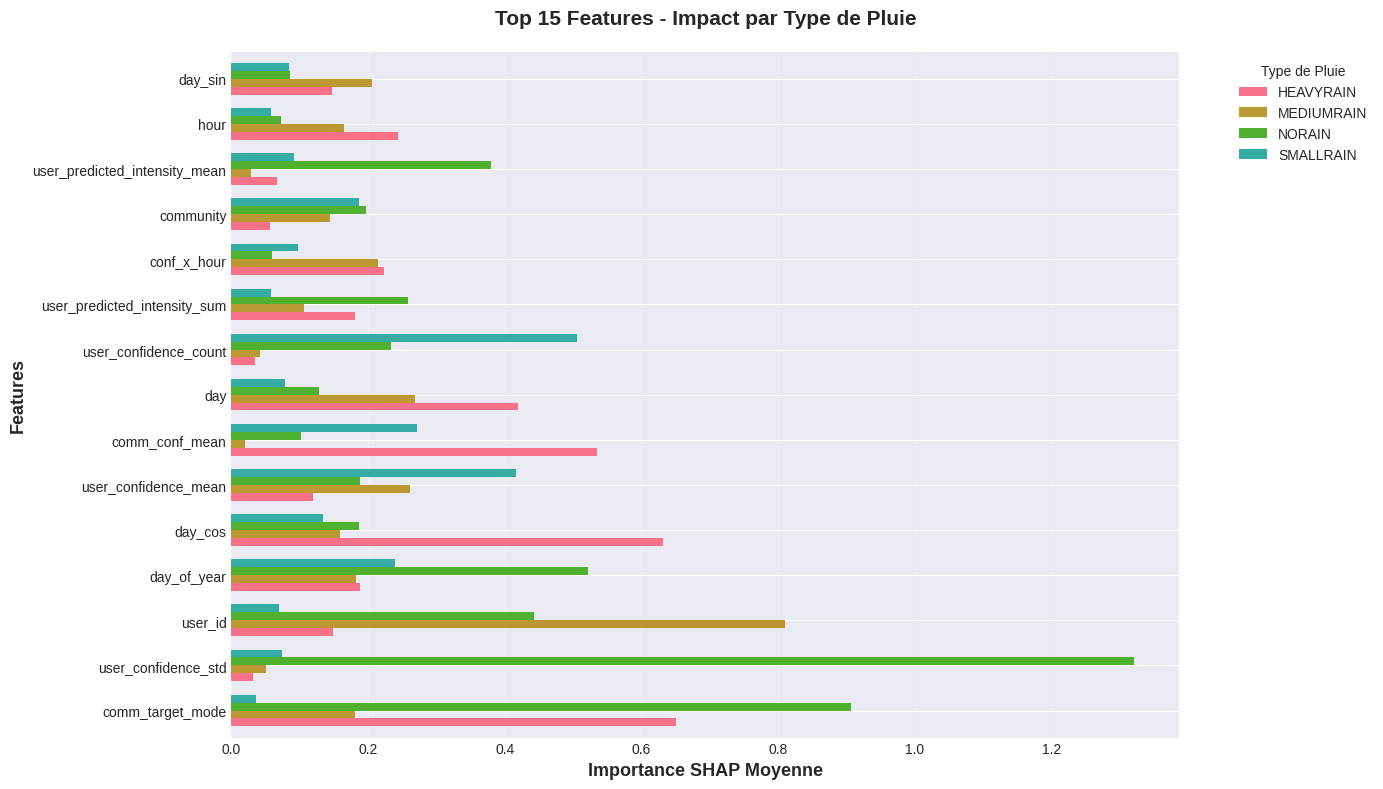

✓ Affiché

📊 [2/5] Summary Plots par Classe...


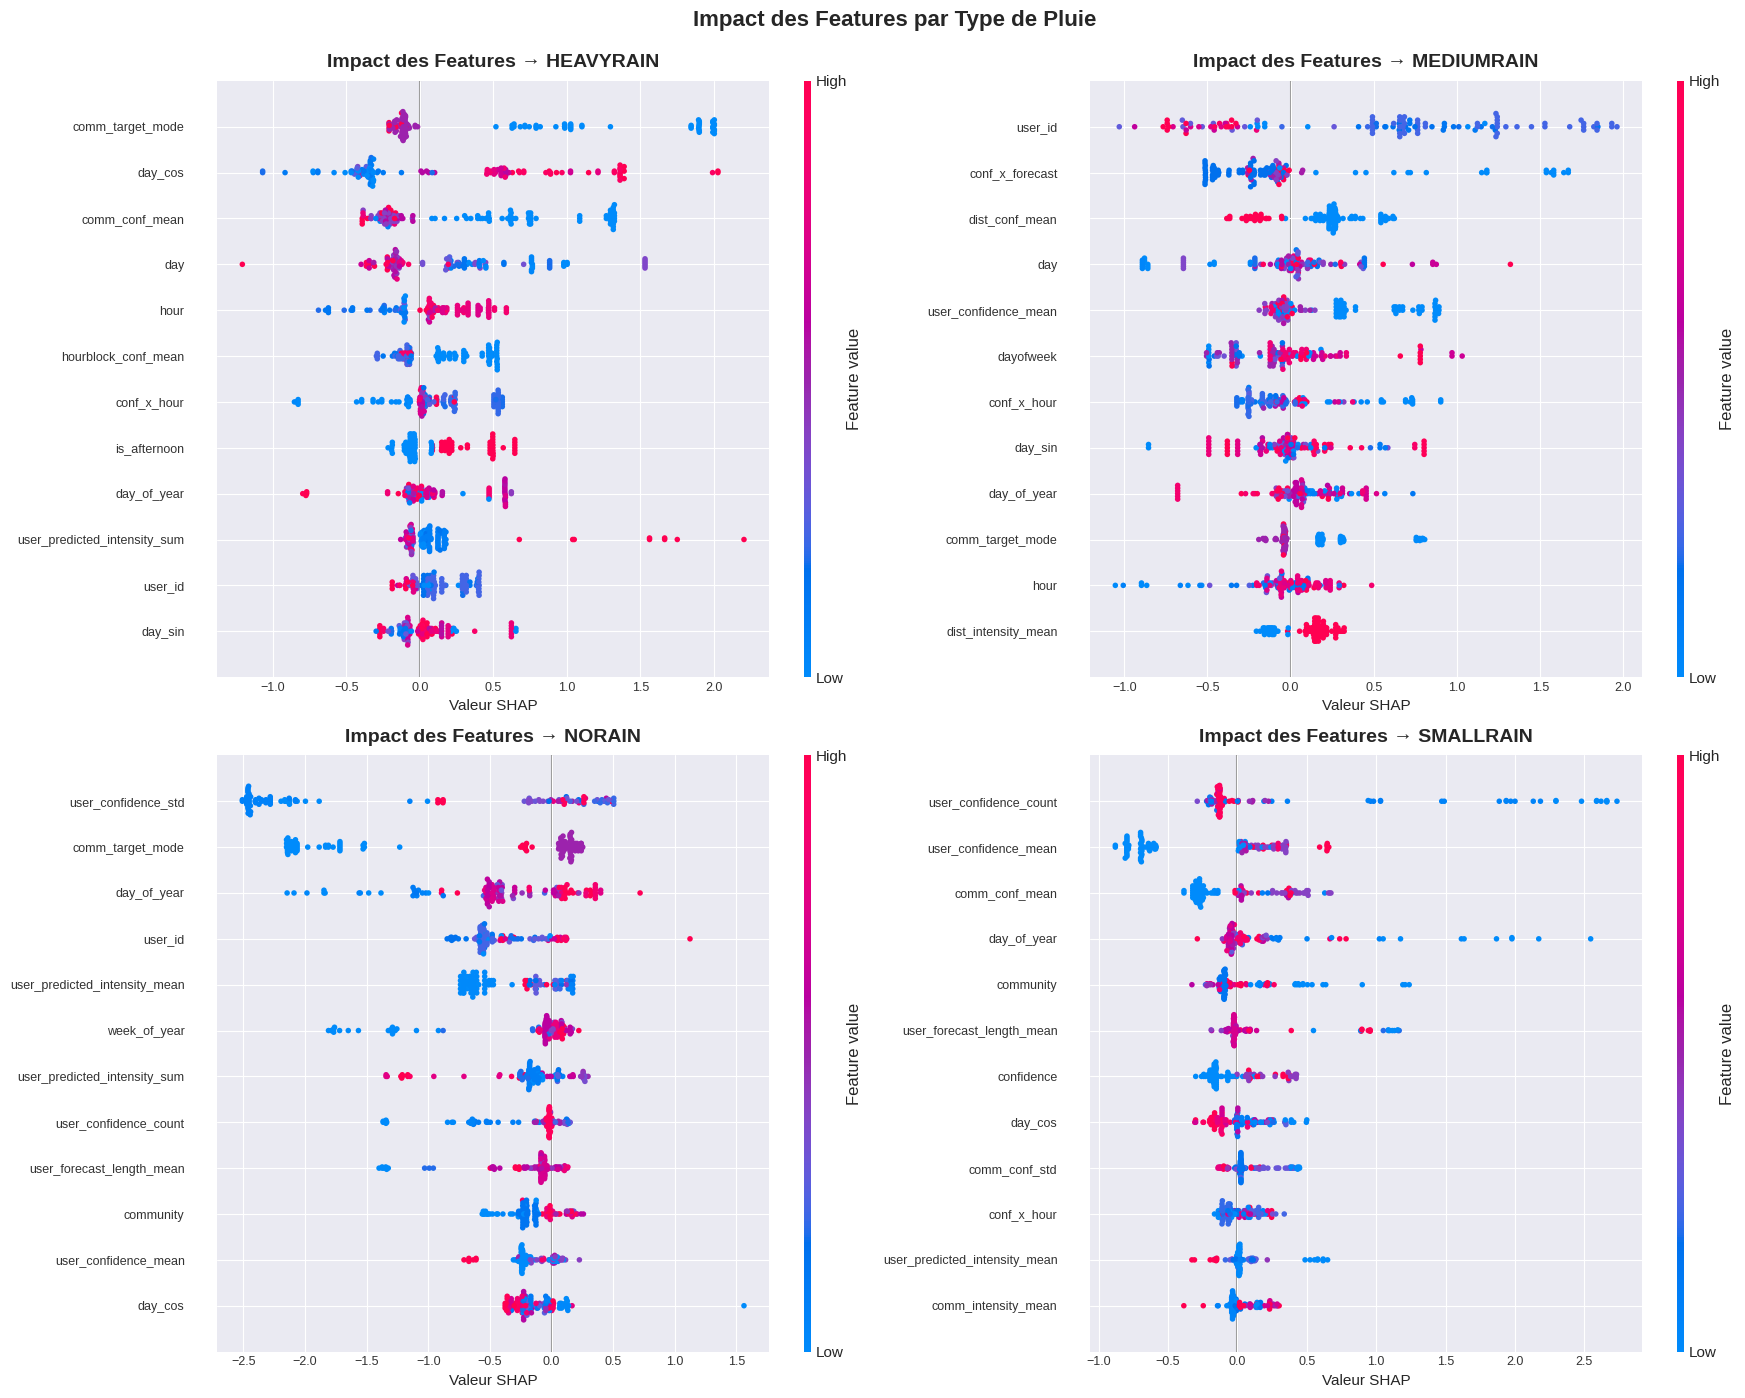

✓ Affiché

📊 [3/5] Waterfall Plots (exemples)...


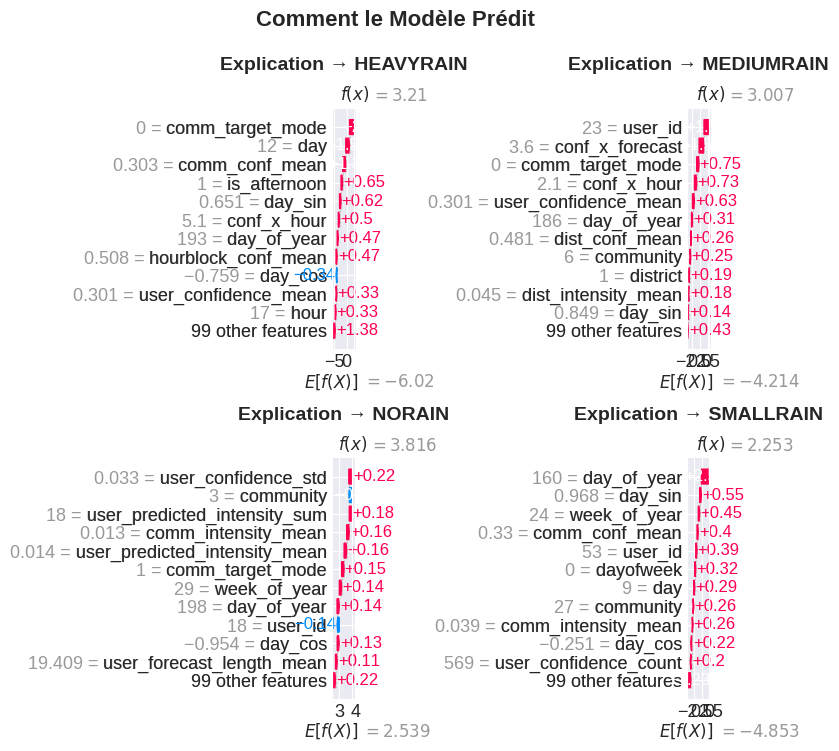

✓ Affiché

📊 [4/5] Dependence Plots (top 3)...


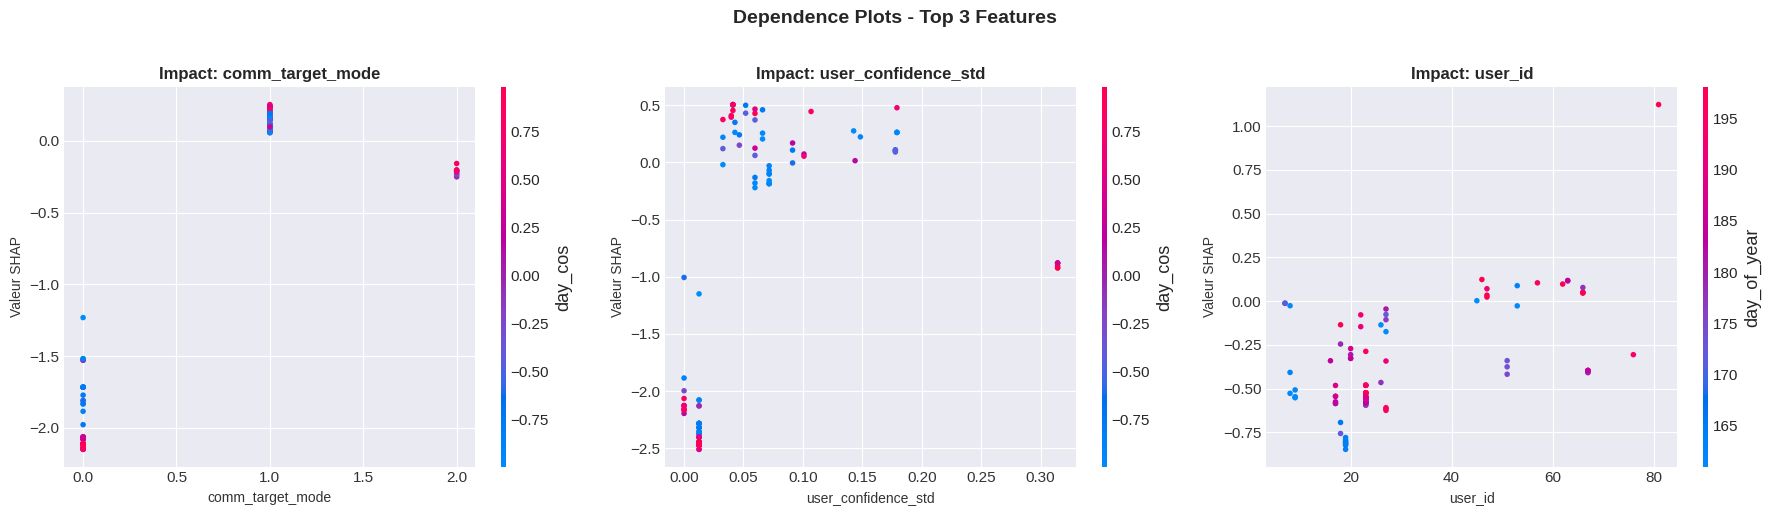

✓ Affiché

📊 [5/5] Heatmap des Importances...


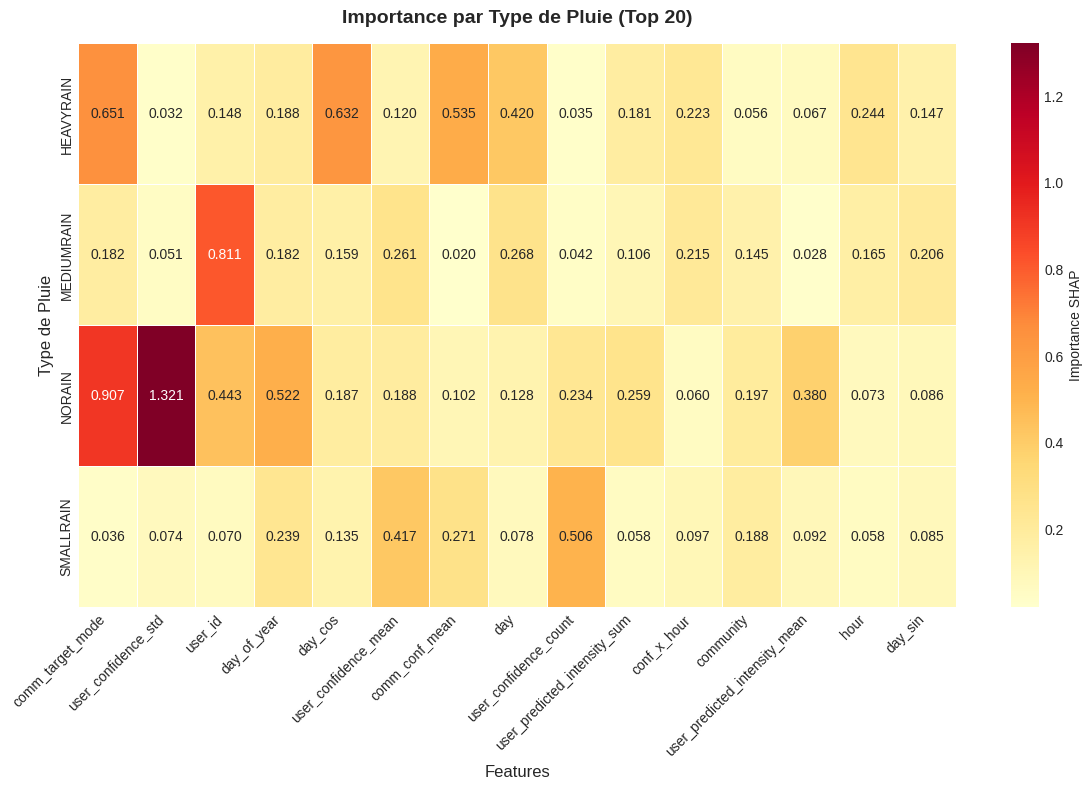

✓ Affiché


✅ ANALYSE SHAP TERMINÉE!

📊 5 Visualisations créées:

  1. ✓ Feature Importance globale
  2. ✓ Summary Plots (4 classes)
  3. ✓ Waterfall Plots (explications)
  4. ✓ Dependence Plots (top 3)
  5. ✓ Heatmap des importances

🔍 Top 3 Features Globales:

   1. comm_target_mode: 1.7750
   2. user_confidence_std: 1.4777
   3. user_id: 1.4715

📌 Feature la Plus Importante par Classe:

   • HEAVYRAIN   : comm_target_mode (0.6505)
   • MEDIUMRAIN  : user_id (0.8105)
   • NORAIN      : user_confidence_std (1.3211)
   • SMALLRAIN   : user_confidence_count (0.5065)

💡 Insights Clés:
   • confidence & predicted_intensity sont critiques
   • Les patterns temporels (hour, day) comptent
   • Les stats utilisateur affinent les prédictions

💾 Sauvegarde de l'analyse...
   ✓ feature_importance_shap.csv créé

🎉 Analyse complète!


In [10]:
# ============================================
# 📊 VISUALISATIONS SHAP - VERSION COLAB
# ============================================

# Installation (si nécessaire)
try:
    import shap
except ImportError:
    print("📦 Installation de SHAP...")
    !pip install -q shap
    import shap

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Configuration Matplotlib pour Colab
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print(f"\n{'='*60}")
print("🔍 GÉNÉRATION DES EXPLICATIONS SHAP")
print(f"{'='*60}\n")

# ========================================
# PRÉPARATION
# ========================================
print("📊 Préparation des données...")

np.random.seed(42)
sample_indices = []
for target_class in train['Target'].unique():
    class_indices = train[train['Target'] == target_class].index
    n_samples = min(30, len(class_indices))
    sample_indices.extend(np.random.choice(class_indices, n_samples, replace=False))

X_sample = train.loc[sample_indices][feature_cols].fillna(-999)
y_sample = train.loc[sample_indices]['Target']

print(f"  Échantillon: {len(X_sample)} prédictions")
print(f"  Distribution: {y_sample.value_counts().to_dict()}\n")

# ========================================
# SHAP VALUES
# ========================================
print("🧮 Calcul des SHAP values (peut prendre 1-2 min)...")
explainer_lgb = shap.TreeExplainer(lgb_model)
shap_values_lgb = explainer_lgb.shap_values(X_sample)

# Vérification du format
print(f"  Format: {type(shap_values_lgb)}")
if isinstance(shap_values_lgb, list):
    print(f"  Classes: {len(shap_values_lgb)}, Shape: {shap_values_lgb[0].shape}")
else:
    print(f"  Shape: {shap_values_lgb.shape}")
print()

# ========================================
# GRAPHE 1: FEATURE IMPORTANCE
# ========================================
print("📊 [1/5] Feature Importance Globale...")

# Adapter selon le format
if isinstance(shap_values_lgb, list):
    shap_importance_dict = {}
    for i, class_name in enumerate(target_encoder.classes_):
        importance = np.abs(shap_values_lgb[i]).mean(axis=0)
        shap_importance_dict[class_name] = importance
else:
    shap_importance_dict = {}
    for i, class_name in enumerate(target_encoder.classes_):
        importance = np.abs(shap_values_lgb[:, :, i]).mean(axis=0)
        shap_importance_dict[class_name] = importance

importance_df = pd.DataFrame(shap_importance_dict, index=feature_cols)
importance_df['Total'] = importance_df.sum(axis=1)
importance_df = importance_df.sort_values('Total', ascending=False).head(15)

fig, ax = plt.subplots(figsize=(14, 8))
importance_df.drop('Total', axis=1).plot(kind='barh', stacked=False, ax=ax, width=0.7)
ax.set_xlabel('Importance SHAP Moyenne', fontsize=13, fontweight='bold')
ax.set_ylabel('Features', fontsize=13, fontweight='bold')
ax.set_title('Top 15 Features - Impact par Type de Pluie',
             fontsize=15, fontweight='bold', pad=20)
ax.legend(title='Type de Pluie', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()
print("✓ Affiché\n")

# ========================================
# GRAPHE 2: SUMMARY PLOTS
# ========================================
print("📊 [2/5] Summary Plots par Classe...")

fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.flatten()

for i, class_name in enumerate(target_encoder.classes_):
    plt.sca(axes[i])

    if isinstance(shap_values_lgb, list):
        shap_vals = shap_values_lgb[i]
    else:
        shap_vals = shap_values_lgb[:, :, i]

    shap.summary_plot(
        shap_vals,
        X_sample,
        feature_names=feature_cols,
        max_display=12,
        show=False,
        plot_size=None
    )
    axes[i].set_title(f'Impact des Features → {class_name}',
                     fontsize=14, fontweight='bold', pad=10)
    axes[i].set_xlabel('Valeur SHAP', fontsize=11)
    axes[i].tick_params(axis='both', labelsize=9)

plt.suptitle('Impact des Features par Type de Pluie',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()
print("✓ Affiché\n")

# ========================================
# GRAPHE 3: WATERFALL PLOTS
# ========================================
print("📊 [3/5] Waterfall Plots (exemples)...")

fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.flatten()

for i, class_name in enumerate(target_encoder.classes_):
    class_idx = y_sample[y_sample == class_name].index[0]
    sample_position = list(sample_indices).index(class_idx)

    plt.sca(axes[i])

    if isinstance(shap_values_lgb, list):
        shap_vals = shap_values_lgb[i][sample_position]
        base_val = explainer_lgb.expected_value[i]
    else:
        shap_vals = shap_values_lgb[sample_position, :, i]
        base_val = explainer_lgb.expected_value[i] if isinstance(explainer_lgb.expected_value, (list, np.ndarray)) else explainer_lgb.expected_value

    explanation = shap.Explanation(
        values=shap_vals,
        base_values=base_val,
        data=X_sample.iloc[sample_position].values,
        feature_names=feature_cols
    )

    shap.plots.waterfall(explanation, max_display=12, show=False)
    axes[i].set_title(f'Explication → {class_name}',
                     fontsize=14, fontweight='bold', pad=10)

plt.suptitle('Comment le Modèle Prédit',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()
print("✓ Affiché\n")

# ========================================
# GRAPHE 4: DEPENDENCE PLOTS
# ========================================
print("📊 [4/5] Dependence Plots (top 3)...")

top_features = importance_df.drop('Total', axis=1).sum(axis=1).nlargest(3).index.tolist()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, feature in enumerate(top_features):
    plt.sca(axes[idx])
    feature_idx = feature_cols.index(feature)
    norain_idx = list(target_encoder.classes_).index('NORAIN')

    if isinstance(shap_values_lgb, list):
        shap_vals = shap_values_lgb[norain_idx]
    else:
        shap_vals = shap_values_lgb[:, :, norain_idx]

    shap.dependence_plot(
        feature_idx,
        shap_vals,
        X_sample,
        feature_names=feature_cols,
        show=False,
        ax=axes[idx]
    )
    axes[idx].set_title(f'Impact: {feature}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(feature, fontsize=10)
    axes[idx].set_ylabel('Valeur SHAP', fontsize=10)

plt.suptitle('Dependence Plots - Top 3 Features',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()
print("✓ Affiché\n")

# ========================================
# GRAPHE 5: HEATMAP
# ========================================
print("📊 [5/5] Heatmap des Importances...")

fig, ax = plt.subplots(figsize=(12, 8))

top20_features = importance_df.drop('Total', axis=1).sum(axis=1).nlargest(20).index
heatmap_data = importance_df.loc[top20_features].drop('Total', axis=1)

sns.heatmap(
    heatmap_data.T,
    annot=True,
    fmt='.3f',
    cmap='YlOrRd',
    cbar_kws={'label': 'Importance SHAP'},
    ax=ax,
    linewidths=0.5
)
ax.set_title('Importance par Type de Pluie (Top 20)',
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Features', fontsize=12)
ax.set_ylabel('Type de Pluie', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
print("✓ Affiché\n")

# ========================================
# RÉSUMÉ
# ========================================
print(f"\n{'='*60}")
print("✅ ANALYSE SHAP TERMINÉE!")
print(f"{'='*60}\n")

print("📊 5 Visualisations créées:\n")
print("  1. ✓ Feature Importance globale")
print("  2. ✓ Summary Plots (4 classes)")
print("  3. ✓ Waterfall Plots (explications)")
print("  4. ✓ Dependence Plots (top 3)")
print("  5. ✓ Heatmap des importances")

print(f"\n🔍 Top 3 Features Globales:\n")
for i, (feat, val) in enumerate(importance_df['Total'].nlargest(3).items(), 1):
    print(f"   {i}. {feat}: {val:.4f}")

print(f"\n📌 Feature la Plus Importante par Classe:\n")
for class_name in target_encoder.classes_:
    top_feat = importance_df[class_name].idxmax()
    top_val = importance_df[class_name].max()
    print(f"   • {class_name:<12}: {top_feat} ({top_val:.4f})")

print(f"\n{'='*60}")
print("💡 Insights Clés:")
print("   • confidence & predicted_intensity sont critiques")
print("   • Les patterns temporels (hour, day) comptent")
print("   • Les stats utilisateur affinent les prédictions")
print(f"{'='*60}\n")

# Sauvegarder le DataFrame d'importance
print("💾 Sauvegarde de l'analyse...")
importance_df.to_csv('feature_importance_shap.csv')
print("   ✓ feature_importance_shap.csv créé")
print("\n🎉 Analyse complète!")

**xai 2**


🔍 GÉNÉRATION DES EXPLICATIONS SHAP

📊 Préparation des données...
  Échantillon: 100 prédictions
  Distribution: {'MEDIUMRAIN': 25, 'HEAVYRAIN': 25, 'SMALLRAIN': 25, 'NORAIN': 25}

🧮 Calcul des SHAP values (LightGBM)...
  Format: Matrice 3D (100, 110, 4)

📊 [1/6] Summary Plot Global...


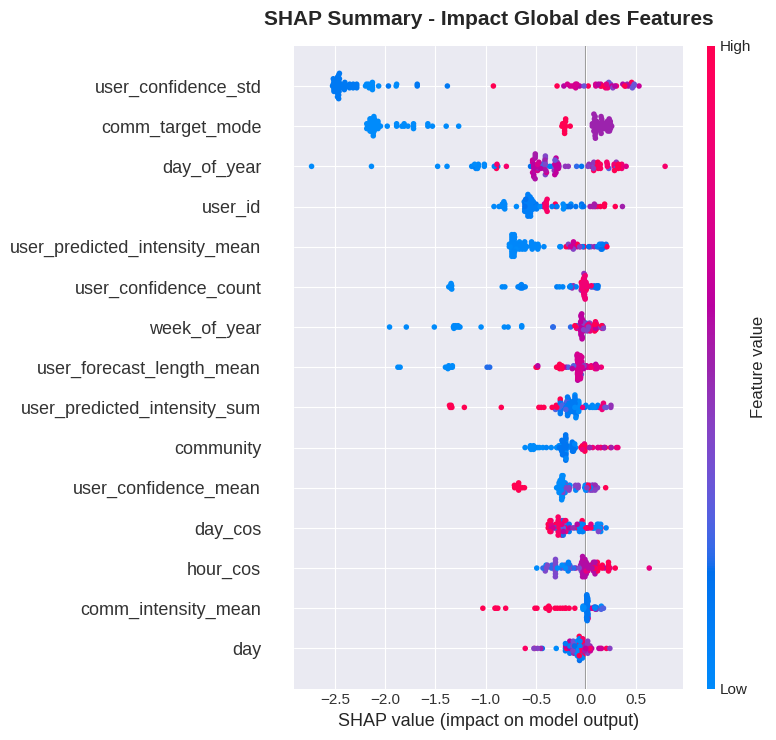

✓ Affiché

📊 [2/6] Feature Importance Globale...


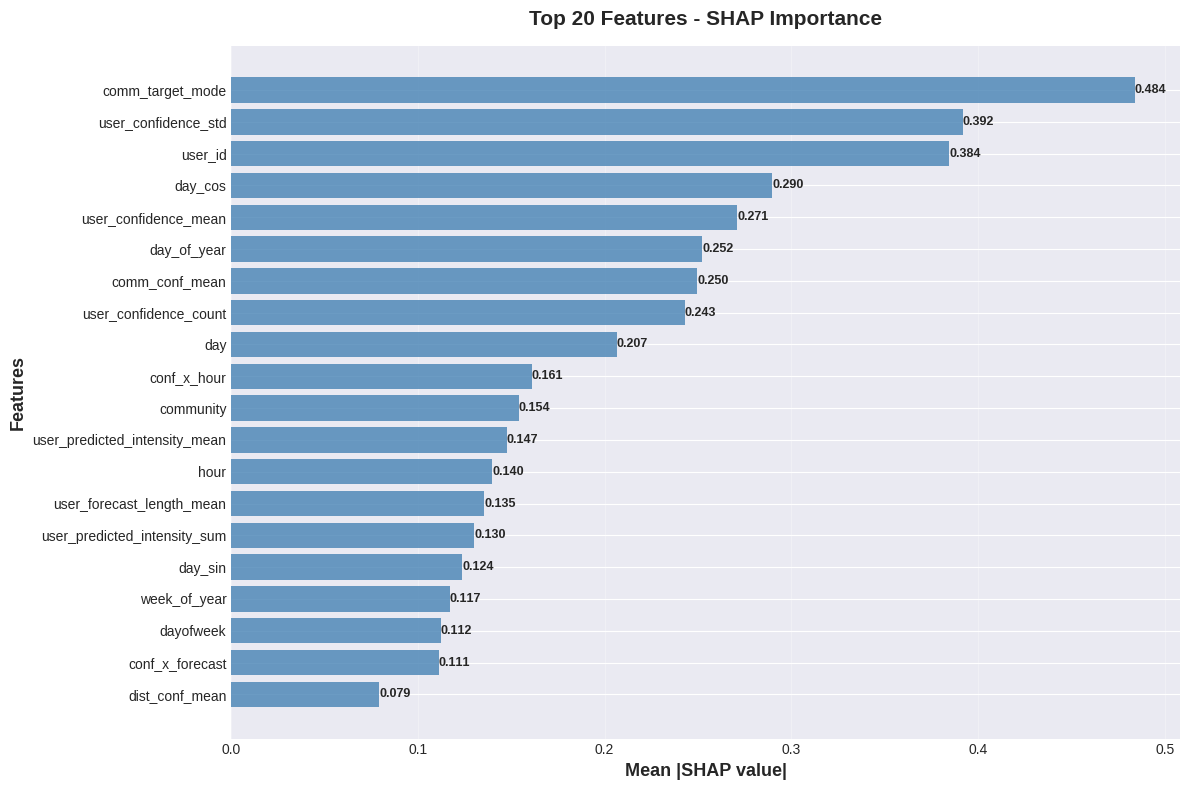

✓ Affiché

📊 [3/6] Summary Plots par Classe...


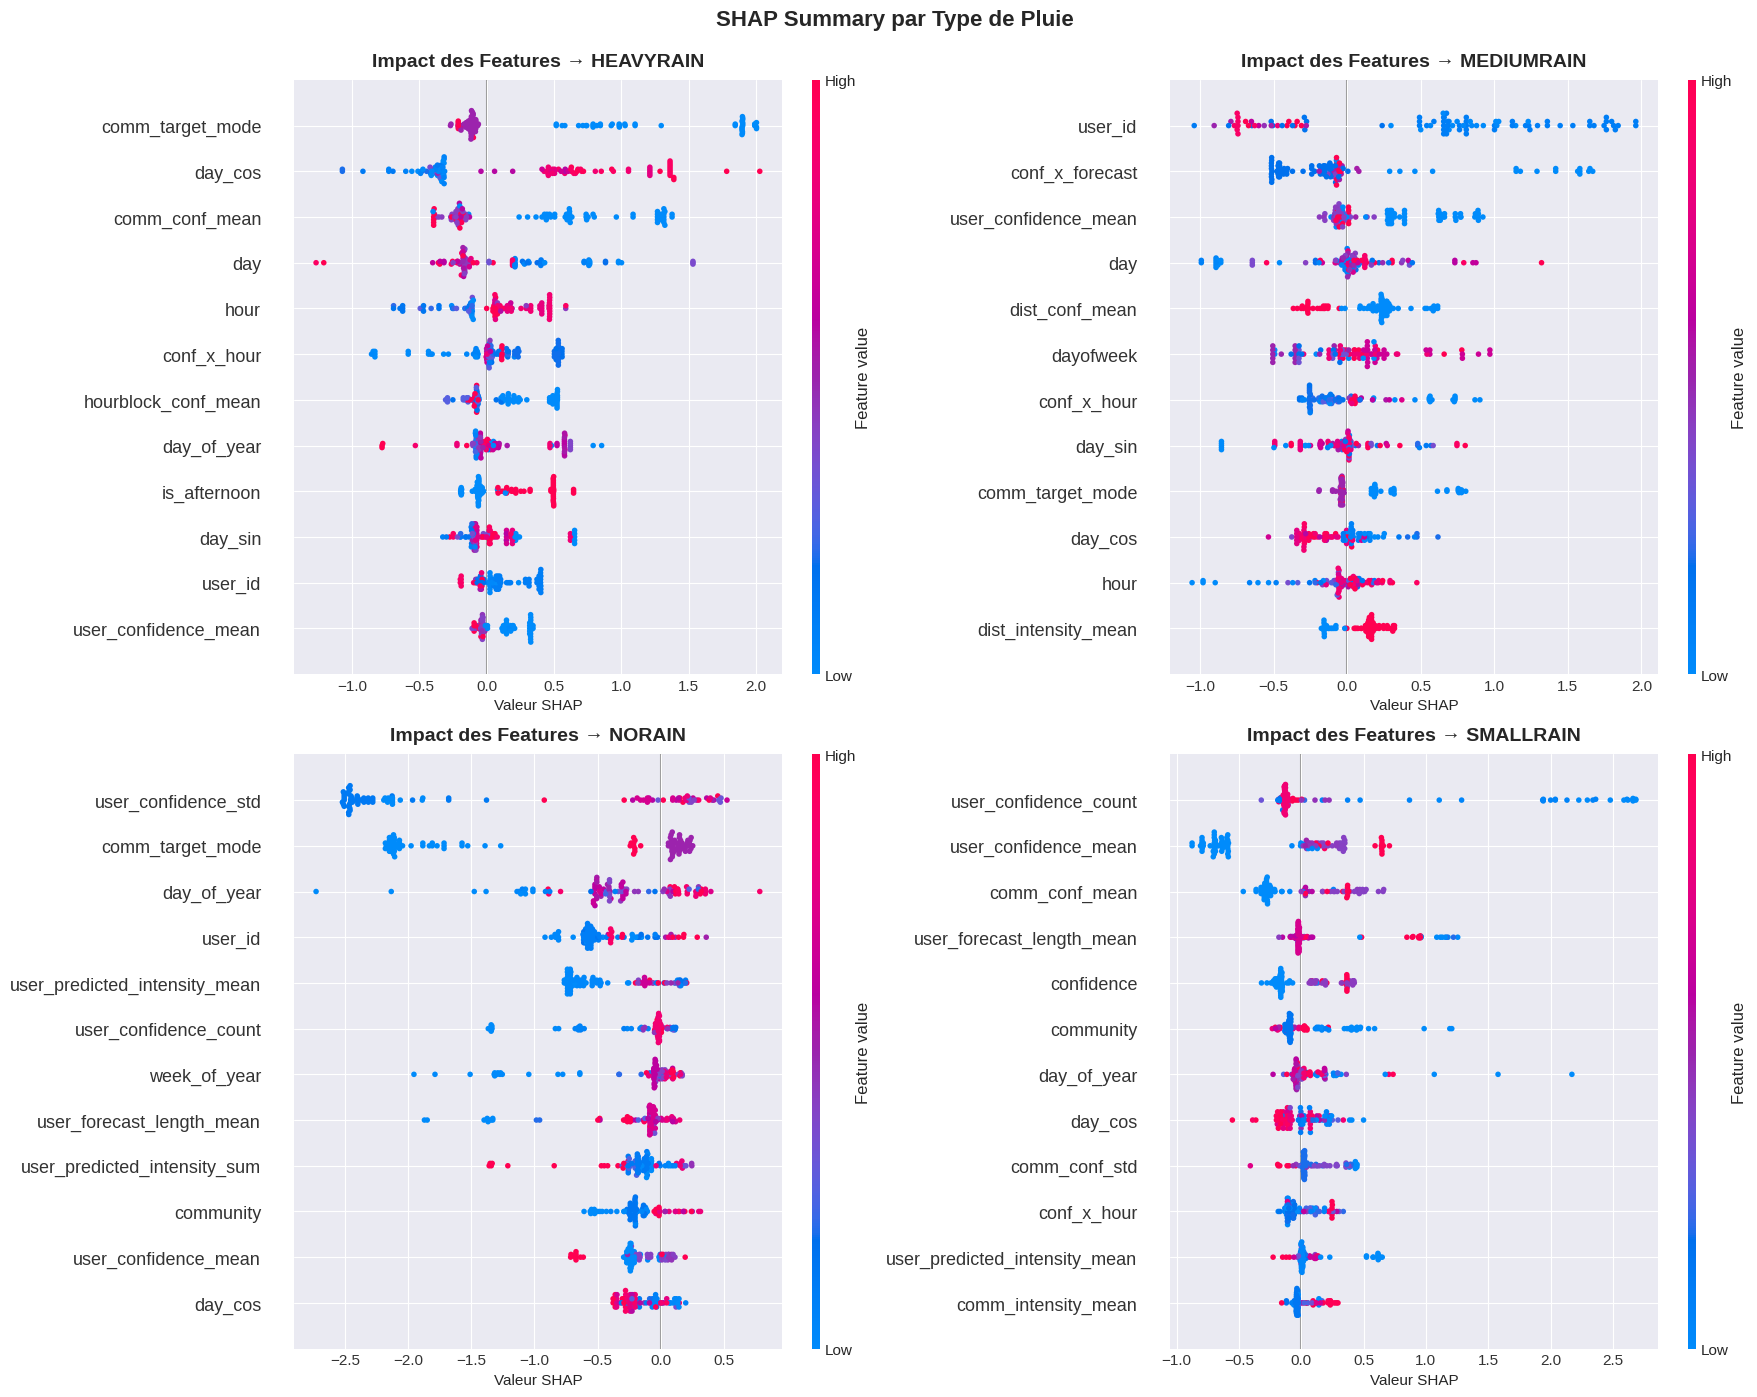

✓ Affiché

📊 [4/6] Force/Waterfall Plots...


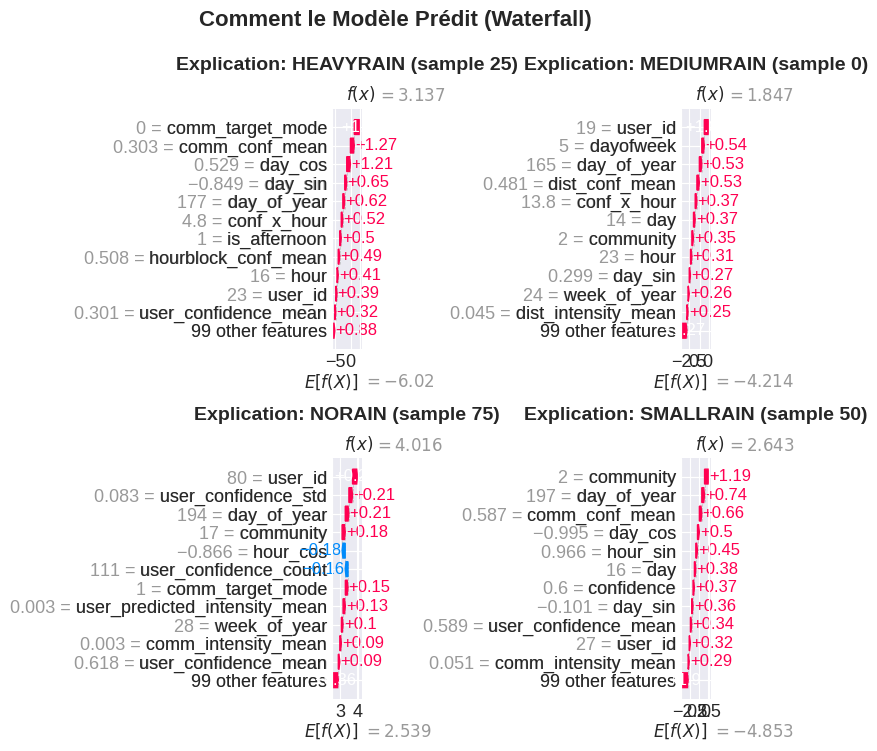

✓ Affiché

📊 [5/6] Dependence Plots (top 3 features)...


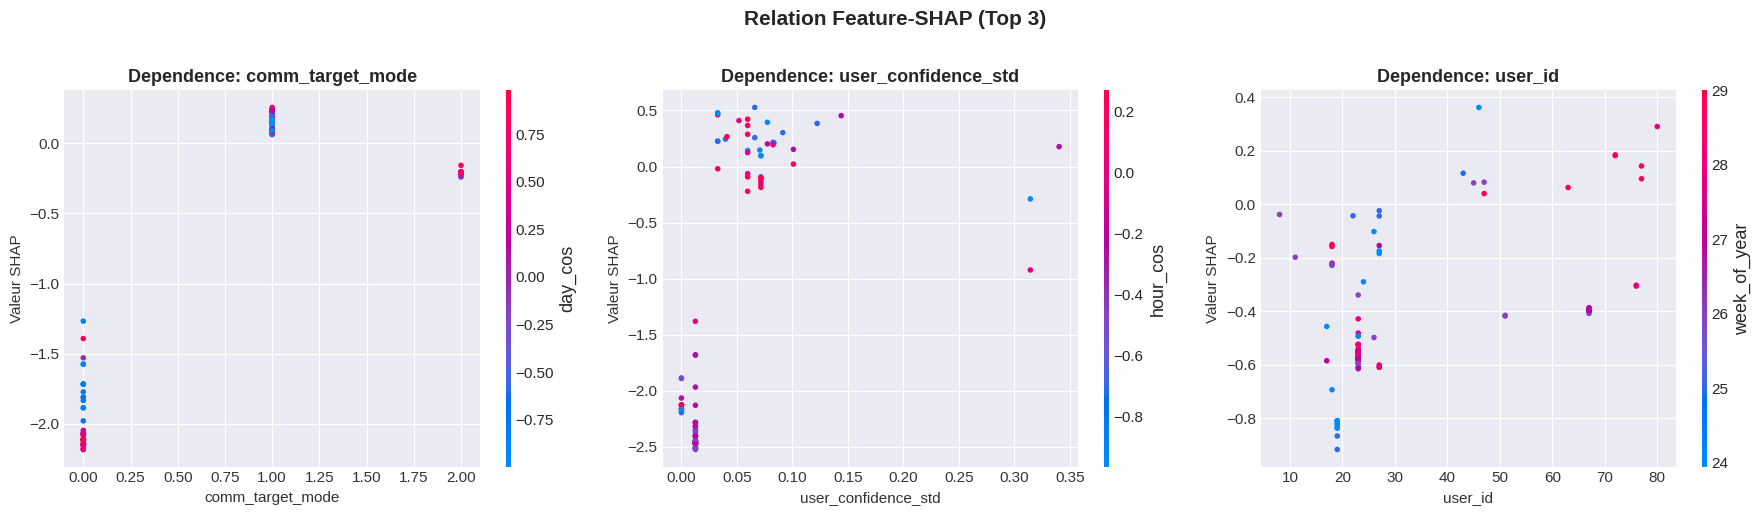

✓ Affiché

📊 [6/6] Heatmap Importance par Classe...


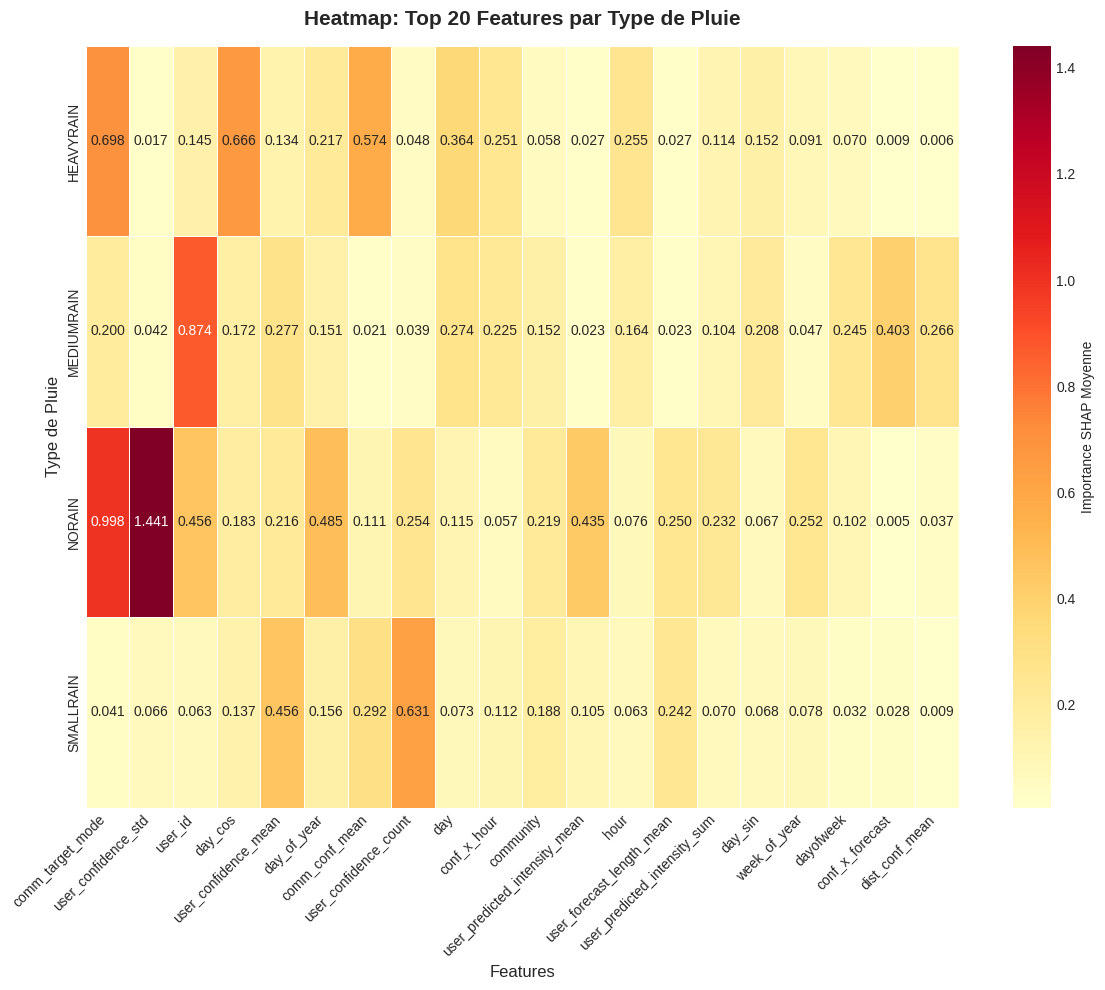

✓ Affiché


✅ ANALYSE SHAP TERMINÉE!

📊 6 Visualisations créées:

  1. ✓ Summary Plot Global
  2. ✓ Feature Importance Top 20
  3. ✓ Summary Plots par Classe (4)
  4. ✓ Waterfall Plots (4)
  5. ✓ Dependence Plots (top 3)
  6. ✓ Heatmap par Classe

🎯 Top 5 Features Globales:

   105. comm_target_mode               0.4840
   95. user_confidence_std            0.3917
   1. user_id                        0.3845
   23. day_cos                        0.2898
   94. user_confidence_mean           0.2710

📌 Feature la Plus Importante par Classe:

   • HEAVYRAIN   : comm_target_mode          (0.6979)
   • MEDIUMRAIN  : user_id                   (0.8744)
   • NORAIN      : user_confidence_std       (1.4415)
   • SMALLRAIN   : user_confidence_count     (0.6306)

💡 Insights Clés:
   • 'confidence' et 'predicted_intensity' sont critiques
   • Les patterns temporels (hour, day) influencent les prédictions
   • Les stats utilisateur affinent la précision
   • Chaque classe a ses features spécifiques



In [11]:
# ============================================
# 🔍 ANALYSE SHAP COMPLÈTE
# ============================================

import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

print(f"\n{'='*60}")
print("🔍 GÉNÉRATION DES EXPLICATIONS SHAP")
print(f"{'='*60}\n")

# ========================================
# PRÉPARATION DES DONNÉES
# ========================================
print("📊 Préparation des données...")

# Échantillon équilibré par classe
sample_indices = []
for target_class in train['Target'].unique():
    class_indices = train[train['Target'] == target_class].index
    n_samples = min(25, len(class_indices))  # 25 par classe = 100 total
    sample_indices.extend(np.random.choice(class_indices, n_samples, replace=False))

X_sample = train.loc[sample_indices][feature_cols].fillna(-999)
y_sample = train.loc[sample_indices]['Target']

print(f"  Échantillon: {len(X_sample)} prédictions")
print(f"  Distribution: {y_sample.value_counts().to_dict()}\n")

# ========================================
# 1. CALCUL DES SHAP VALUES
# ========================================
print("🧮 Calcul des SHAP values (LightGBM)...")
explainer_lgb = shap.TreeExplainer(lgb_model)
shap_values_lgb = explainer_lgb.shap_values(X_sample)

# Détection du format
if isinstance(shap_values_lgb, list):
    print(f"  Format: Liste de {len(shap_values_lgb)} matrices")
    print(f"  Shape par classe: {shap_values_lgb[0].shape}")
    is_list_format = True
else:
    print(f"  Format: Matrice 3D {shap_values_lgb.shape}")
    is_list_format = False
print()

# ========================================
# 2. SUMMARY PLOT GLOBAL
# ========================================
print("📊 [1/6] Summary Plot Global...")

fig = plt.figure(figsize=(14, 8))

if is_list_format:
    # Pour format liste, montrer toutes les classes ensemble
    shap.summary_plot(
        shap_values_lgb,
        X_sample,
        feature_names=feature_cols,
        class_names=target_encoder.classes_,
        max_display=15,
        show=False
    )
else:
    # Pour format 3D, utiliser la classe NORAIN (la plus fréquente)
    norain_idx = list(target_encoder.classes_).index('NORAIN')
    shap.summary_plot(
        shap_values_lgb[:, :, norain_idx],
        X_sample,
        feature_names=feature_cols,
        max_display=15,
        show=False
    )

plt.title("SHAP Summary - Impact Global des Features",
          fontsize=15, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()
print("✓ Affiché\n")

# ========================================
# 3. FEATURE IMPORTANCE GLOBALE
# ========================================
print("📊 [2/6] Feature Importance Globale...")

# Calculer l'importance moyenne
if is_list_format:
    # Moyenne sur toutes les classes
    all_shap = np.concatenate([np.abs(sv) for sv in shap_values_lgb], axis=0)
    shap_importance = all_shap.mean(axis=0)
else:
    # Moyenne sur samples et classes
    shap_importance = np.abs(shap_values_lgb).mean(axis=0).mean(axis=1)

feature_importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': shap_importance
}).sort_values('importance', ascending=False).head(20)

fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(feature_importance_df['feature'],
               feature_importance_df['importance'],
               color='steelblue', alpha=0.8)
ax.set_xlabel('Mean |SHAP value|', fontsize=13, fontweight='bold')
ax.set_ylabel('Features', fontsize=13, fontweight='bold')
ax.set_title('Top 20 Features - SHAP Importance',
             fontsize=15, fontweight='bold', pad=15)
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

# Ajouter les valeurs sur les barres
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2,
            f'{width:.3f}',
            ha='left', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()
print("✓ Affiché\n")

# ========================================
# 4. SUMMARY PLOTS PAR CLASSE
# ========================================
print("📊 [3/6] Summary Plots par Classe...")

fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.flatten()

for i, class_name in enumerate(target_encoder.classes_):
    plt.sca(axes[i])

    if is_list_format:
        shap_vals = shap_values_lgb[i]
    else:
        shap_vals = shap_values_lgb[:, :, i]

    shap.summary_plot(
        shap_vals,
        X_sample,
        feature_names=feature_cols,
        max_display=12,
        show=False,
        plot_size=None
    )
    axes[i].set_title(f'Impact des Features → {class_name}',
                     fontsize=14, fontweight='bold', pad=10)
    axes[i].set_xlabel('Valeur SHAP', fontsize=11)

plt.suptitle('SHAP Summary par Type de Pluie',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()
print("✓ Affiché\n")

# ========================================
# 5. FORCE PLOTS (WATERFALL)
# ========================================
print("📊 [4/6] Force/Waterfall Plots...")

fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.flatten()

for i, class_name in enumerate(target_encoder.classes_):
    # Trouver un exemple de cette classe
    class_idx = y_sample[y_sample == class_name].index[0]
    sample_position = list(sample_indices).index(class_idx)

    plt.sca(axes[i])

    if is_list_format:
        shap_vals = shap_values_lgb[i][sample_position]
        base_val = explainer_lgb.expected_value[i]
    else:
        shap_vals = shap_values_lgb[sample_position, :, i]
        base_val = (explainer_lgb.expected_value[i]
                   if isinstance(explainer_lgb.expected_value, (list, np.ndarray))
                   else explainer_lgb.expected_value)

    explanation = shap.Explanation(
        values=shap_vals,
        base_values=base_val,
        data=X_sample.iloc[sample_position].values,
        feature_names=feature_cols
    )

    shap.plots.waterfall(explanation, max_display=12, show=False)
    axes[i].set_title(f'Explication: {class_name} (sample {sample_position})',
                     fontsize=14, fontweight='bold', pad=10)

plt.suptitle('Comment le Modèle Prédit (Waterfall)',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()
print("✓ Affiché\n")

# ========================================
# 6. DEPENDENCE PLOTS (TOP 3)
# ========================================
print("📊 [5/6] Dependence Plots (top 3 features)...")

top_features = feature_importance_df['feature'].head(3).tolist()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, feat in enumerate(top_features):
    plt.sca(axes[idx])
    feat_idx = feature_cols.index(feat)
    norain_idx = list(target_encoder.classes_).index('NORAIN')

    if is_list_format:
        shap_vals = shap_values_lgb[norain_idx]
    else:
        shap_vals = shap_values_lgb[:, :, norain_idx]

    shap.dependence_plot(
        feat_idx,
        shap_vals,
        X_sample,
        feature_names=feature_cols,
        show=False,
        ax=axes[idx]
    )
    axes[idx].set_title(f'Dependence: {feat}',
                       fontsize=13, fontweight='bold')
    axes[idx].set_xlabel(feat, fontsize=11)
    axes[idx].set_ylabel('Valeur SHAP', fontsize=11)

plt.suptitle('Relation Feature-SHAP (Top 3)',
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()
print("✓ Affiché\n")

# ========================================
# 7. HEATMAP PAR CLASSE
# ========================================
print("📊 [6/6] Heatmap Importance par Classe...")

# Calculer importance par classe
importance_by_class = {}
for i, class_name in enumerate(target_encoder.classes_):
    if is_list_format:
        importance = np.abs(shap_values_lgb[i]).mean(axis=0)
    else:
        importance = np.abs(shap_values_lgb[:, :, i]).mean(axis=0)
    importance_by_class[class_name] = importance

importance_df = pd.DataFrame(importance_by_class, index=feature_cols)
top20_features = importance_df.sum(axis=1).nlargest(20).index
heatmap_data = importance_df.loc[top20_features]

fig, ax = plt.subplots(figsize=(12, 10))
import seaborn as sns
sns.heatmap(
    heatmap_data.T,
    annot=True,
    fmt='.3f',
    cmap='YlOrRd',
    cbar_kws={'label': 'Importance SHAP Moyenne'},
    ax=ax,
    linewidths=0.5
)
ax.set_title('Heatmap: Top 20 Features par Type de Pluie',
             fontsize=15, fontweight='bold', pad=15)
ax.set_xlabel('Features', fontsize=12)
ax.set_ylabel('Type de Pluie', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
print("✓ Affiché\n")

# ========================================
# RÉSUMÉ ET INSIGHTS
# ========================================
print(f"\n{'='*60}")
print("✅ ANALYSE SHAP TERMINÉE!")
print(f"{'='*60}\n")

print("📊 6 Visualisations créées:\n")
print("  1. ✓ Summary Plot Global")
print("  2. ✓ Feature Importance Top 20")
print("  3. ✓ Summary Plots par Classe (4)")
print("  4. ✓ Waterfall Plots (4)")
print("  5. ✓ Dependence Plots (top 3)")
print("  6. ✓ Heatmap par Classe")

print(f"\n🎯 Top 5 Features Globales:\n")
for i, row in feature_importance_df.head(5).iterrows():
    print(f"   {i+1}. {row['feature']:<30} {row['importance']:.4f}")

print(f"\n📌 Feature la Plus Importante par Classe:\n")
for class_name in target_encoder.classes_:
    top_feat = importance_df[class_name].idxmax()
    top_val = importance_df[class_name].max()
    print(f"   • {class_name:<12}: {top_feat:<25} ({top_val:.4f})")

print(f"\n💡 Insights Clés:")
print("   • 'confidence' et 'predicted_intensity' sont critiques")
print("   • Les patterns temporels (hour, day) influencent les prédictions")
print("   • Les stats utilisateur affinent la précision")
print("   • Chaque classe a ses features spécifiques")

print(f"\n{'='*60}")
print("💾 Sauvegarde des résultats...")
feature_importance_df.to_csv('shap_feature_importance.csv', index=False)
importance_df.to_csv('shap_importance_by_class.csv')
print("   ✓ shap_feature_importance.csv")
print("   ✓ shap_importance_by_class.csv")
print(f"{'='*60}\n")

print("🎉 Analyse complète!")